In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
# import joypy as jp
from itertools import zip_longest
from scipy.stats import linregress, entropy, pearsonr
from scipy import stats

dat_path = os.getcwd()[:-4] + 'data/'
figures_path = os.getcwd()[:-4] + 'figures/'
prelim_fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-4] + 'data/generated_data/'

text_font = 30

In [2]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [3]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [4]:
def count_streaks_aggregated(sequence, streak_type):
    """
    Count and aggregate the lengths of streaks (either hot or cold) of a certain length or longer.

    :param sequence: Sequence of game outcomes (1s and 0s).
    :param streak_type: Type of streak to count ('hot' for wins, 'cold' for losses).
    :return: A dictionary where keys are minimum streak lengths and values are aggregated counts.
    """
    aggregated_streaks = {}
    current_streak = 0
    streak_value = 1 if streak_type == 'hot' else 0

    for outcome in sequence:
        if outcome == streak_value:
            current_streak += 1
        elif current_streak > 0:
            for length in range(1, current_streak + 1):
                aggregated_streaks[length] = aggregated_streaks.get(length, 0) + 1
            current_streak = 0

    # If the sequence ends with a streak, count it
    if current_streak > 0:
        for length in range(1, current_streak + 1):
            aggregated_streaks[length] = aggregated_streaks.get(length, 0) + 1

    return aggregated_streaks

# count_streaks_aggregated([1,1,1,0,0,0,1], 'hot')

In [5]:
def streak_data(norm_quant, min_matches, rand_num):
    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final = odi_final.drop_duplicates(subset=['Match_ID', 'Team'])

    team_list = odi_final['Team'].unique()

    streak_length = 100

    full_data_hot = np.zeros((len(team_list), streak_length))
    full_data_cold = np.zeros((len(team_list), streak_length))

    full_error_hot = np.zeros((len(team_list), streak_length))
    full_error_cold = np.zeros((len(team_list), streak_length))

    for t, team in enumerate(team_list):
            
        team_df = odi_final[odi_final['Team'] == team]
        team_df = team_df.reset_index(drop=True)

        if len(team_df) > min_matches:

            temp_hot_streak_array = np.zeros((rand_num, streak_length))
            temp_cold_streak_array = np.zeros((rand_num, streak_length))

            dat_series = []

            for i in range(len(team_df)):
                if team_df['Winner'].iloc[i] == team:
                    dat_series.append(1)
                else:
                    dat_series.append(0)

            _dat_hot = count_streaks_aggregated(dat_series, 'hot')
            _dat_cold = count_streaks_aggregated(dat_series, 'cold')

            for r in range(rand_num):

                temp_dat_series = np.random.permutation(dat_series)

                temp_dat_hot = count_streaks_aggregated(temp_dat_series, 'hot')
                temp_dat_cold = count_streaks_aggregated(temp_dat_series, 'cold')


                for length in temp_dat_hot.keys():
                    temp_hot_streak_array[r, length] = temp_dat_hot[length]

                for length in temp_dat_cold.keys():
                    temp_cold_streak_array[r, length] = temp_dat_cold[length]


            _rnd_hot_mean = np.nanmean(temp_hot_streak_array, axis=0)
            _rnd_cold_mean = np.nanmean(temp_cold_streak_array, axis=0)

            _rnd_hot_std = np.nanstd(temp_hot_streak_array, axis=0)
            _rnd_cold_std = np.nanstd(temp_cold_streak_array, axis=0)

            for length in _dat_hot.keys():
                full_data_hot[t, length] = (_dat_hot[length]/ _rnd_hot_mean[length])

            for length in _dat_cold.keys():
                full_data_cold[t, length] = (_dat_cold[length]/ _rnd_cold_mean[length])

            for length in _dat_hot.keys():
                full_error_hot[t, length] =  _rnd_hot_std[length]

            for length in _dat_cold.keys():
                full_error_cold[t, length] =  _rnd_cold_std[length]

            
        print(t, ' ', team, ' is done.')
    
    with open(generated_dat_path + f'hot_streak_z_score_data_ratio_renorm_{norm_quant}_minmatch_{min_matches}_rnd_{rand_num}.pkl', 'wb') as f:
        pickle.dump([full_data_hot, full_data_cold, full_error_hot, full_error_cold], f)

# streak_data(norm_quant='Runs', min_matches=200, rand_num=10000)

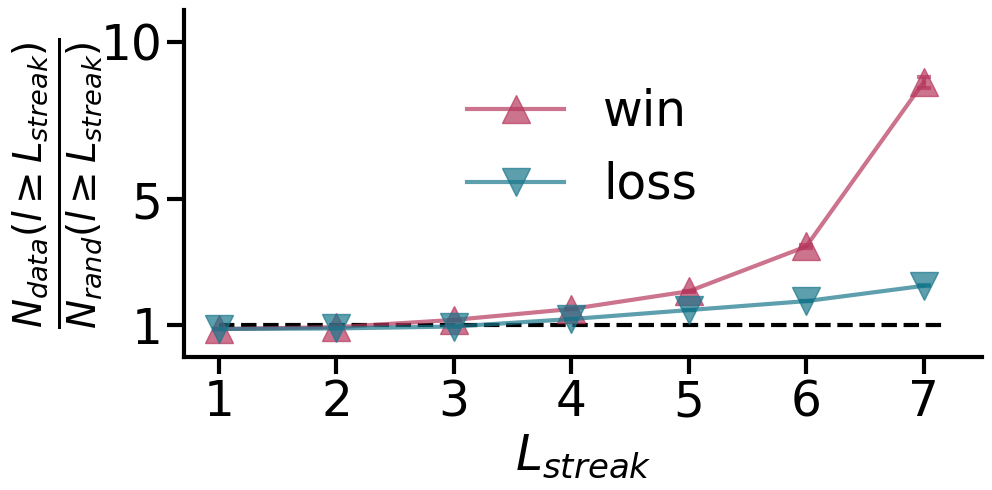

In [6]:
def streak_plot(norm_quant, min_matches, rand_num):

    with open(generated_dat_path + f'hot_streak_z_score_data_ratio_renorm_{norm_quant}_minmatch_{min_matches}_rnd_{rand_num}.pkl', 'rb') as f:
        full_data_hot, full_data_cold, full_error_hot, full_error_cold = pickle.load(f)

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    # color_list = ['red', 'blue']
    color_list = ['#B7385E', '#19778B']

    hot_dat = []
    cold_dat = []
    hot_err = []
    cold_err = []

    for i in range(100):
        temp_hot_dat = [x for x in full_data_hot[:,i] if x != 0]
        temp_cold_dat = [x for x in full_data_cold[:,i] if x != 0]

        temp_hot_err = [x for x in full_error_hot[:,i] if x != 0]
        temp_cold_err = [x for x in full_error_cold[:,i] if x != 0]

        if temp_hot_dat:
            hot_dat.append(np.nanmean(temp_hot_dat))

        if temp_cold_dat:
            cold_dat.append(np.nanmean(temp_cold_dat))

        if temp_hot_err:
            hot_err.append(np.nanstd(temp_hot_dat)/np.sqrt(rand_num))

        if temp_cold_err:
            cold_err.append(np.nanstd(temp_cold_dat)/np.sqrt(rand_num))

    ax.errorbar(np.arange(7), hot_dat[:7], yerr=hot_err[:7], color=color_list[0], alpha = 0.7, marker='^', markersize=20, linewidth = 3, capsize=5, capthick=3)
    ax.errorbar(np.arange(7), cold_dat[:7], yerr=cold_err[:7], color=color_list[1], alpha = 0.7, marker='v', markersize=20, linewidth = 3, capsize=5, capthick=3)

    ax.plot([],[], color=color_list[0], alpha = 0.7, marker='^', markersize=20, linewidth = 3, label='win')
    ax.plot([],[], color=color_list[1], alpha = 0.7, marker='v', markersize=20, linewidth = 3, label='loss')

    # ax.set_xlabel('Number of consecutive results', fontsize=text_font)
    ax.set_xlabel(rf'$L_{{streak}}$', fontsize=text_font+5)
    ax.set_ylabel(r'$  \frac{N_{data}(l \geq L_{streak})}{ N_{rand} (l \geq L_{streak}) } $', fontsize=text_font+10)

    ax.hlines(1, 0, 6.2, linewidth=3, color='black', linestyle='--')

    axis_decor(ax, text_font, 12, 5, 3)

    ax.set_xticks([0,1,2,3,4,5,6], ['1','2','3','4','5','6','7'], fontsize=text_font+5)
    ax.set_yticks([1, 5, 10], [1, 5, 10], fontsize=text_font+5)

    ax.yaxis.set_label_coords(-0.1,0.5)

    ax.set_xlim(-0.3,6.5)
    ax.set_ylim(0,11)

    ax.legend(fontsize=text_font+5, loc='upper left', bbox_to_anchor=(0.3, 0.7, 0.2, 0.2), frameon=False)

    plt.tight_layout()
    plt.savefig(prelim_fig_path + f'streak_plot_renorm_{norm_quant}_nmatch_{min_matches}_rnd_{rand_num}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

streak_plot(norm_quant='Runs', min_matches=200, rand_num=10000)

In [7]:
def effective_team_size_winloss_data(norm_quant):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])
    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    match_num_list = np.unique(odi_final['Match_ID'])

    column_list = ['search_ID','Match_ID', 'Match_Date','Team','Overs', 'Runs', 'renormalized_runs',
       'Wickets', 'Captain', 'Winner', 'effective_team_size']

    new_df = pd.DataFrame(columns=column_list)

    for match_num in tqdm(match_num_list):

        match_df = odi_final[odi_final['Match_ID'] == match_num]

        team_list = np.unique(match_df['Team'])

        for team in team_list:

            team_df = match_df[match_df['Team'] == team]

            temp_dat = [0]*len(column_list)

            contribution_list = []
            # if len(team_df) < 11:
            #     print('error')
                
            for i in range(len(team_df)):
                temp_contri = 0

                ##batsmen
                if np.isfinite(team_df.iloc[i]['renormalized_bat_run']):
                    if np.sum(team_df['renormalized_bat_run']) != 0:
                        temp_contri += 0.5*(team_df.iloc[i]['renormalized_bat_run']/np.sum(team_df['renormalized_bat_run']))

                ##bowlers
                if np.isfinite(team_df.iloc[i]['bowl_wickets']):
                    if np.isfinite(team_df.iloc[i]['bowl_wickets']):
                        if np.sum(team_df['bowl_wickets']) != 0:
                            temp_contri += 0.5*(team_df.iloc[i]['bowl_wickets']/np.sum(team_df['bowl_wickets']))

                contribution_list.append(temp_contri)
            
            ##name of the captain
            captain_df = team_df[team_df['captain'] == 1]

            if not captain_df.empty:
                captain_name = captain_df.iloc[0]['player_name']
            else:
                captain_name = None  # or some other default value


            ##effective team size for the team based on entropy measures
            while len(contribution_list) < 11:
                contribution_list.append(0)

            if np.sum(contribution_list) == 1:
                ent = entropy(contribution_list, base=2)
                effective_team_size = 2**ent
            else:
                effective_team_size = np.nan

            temp_dat[column_list.index('search_ID')] = team_df['search_ID'].iloc[0]
            temp_dat[column_list.index('Match_ID')] = team_df['Match_ID'].iloc[0]
            temp_dat[column_list.index('Match_Date')] = team_df['Match_Date'].iloc[0]
            temp_dat[column_list.index('Team')] = team_df['Team'].iloc[0]
            temp_dat[column_list.index('Overs')] = team_df['Overs'].iloc[0]
            temp_dat[column_list.index('Runs')] = team_df['Runs'].iloc[0]
            temp_dat[column_list.index('renormalized_runs')] = team_df['renormalized_runs'].iloc[0]
            temp_dat[column_list.index('Wickets')] = team_df['Wickets'].iloc[0]
            temp_dat[column_list.index('Captain')] = captain_name
            temp_dat[column_list.index('Winner')] = team_df['Winner'].iloc[0]
            temp_dat[column_list.index('effective_team_size')] = effective_team_size

            new_df.loc[len(new_df)] = temp_dat

    new_df = new_df[np.isfinite(new_df['effective_team_size'])]

    new_df.to_csv(generated_dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_effective_team_size.csv', index=False)

# effective_team_size_winloss_data(norm_quant='Runs')

6.696686611103475 6.941038930131773
6.609544463658585 6.924167449704205
-0.03648854026155988
1.2170201198171907e-12
7.26631609921575e-18
2.1049297839305997e-21
size effect: 73320.21975066868
size effect 1 2: 0.4360035336545926
size effect 2 1: 0.5639964663454073
1 vs 2: 3973523.0
2 vs 1: 5139988.0


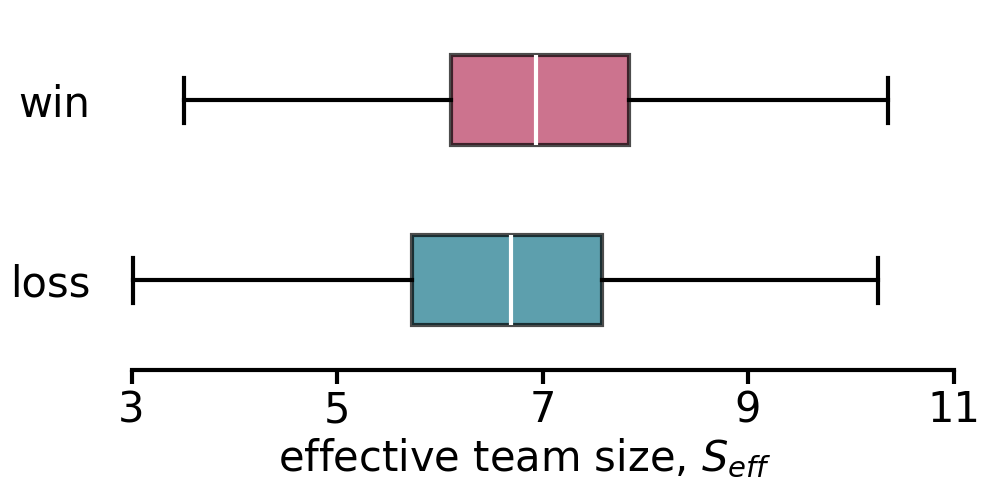

In [13]:
def effective_team_size_winloss_plot(norm_quant):

    team_size_df = pd.read_csv(generated_dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_effective_team_size.csv')

    team_size_df = team_size_df.sort_values(by=['Match_ID','Team'])

    win_ind = np.where(team_size_df['Winner'] == team_size_df['Team'])[0]
    loss_ind = np.where(team_size_df['Winner'] != team_size_df['Team'])[0]

    win_df = team_size_df.iloc[win_ind]
    loss_df = team_size_df.iloc[loss_ind]


    fig, ax = plt.subplots(1,1,figsize=(10,5))

    # box_colors = ['#177880', '#DE5A19']
    # box_colors = ['blue', 'red']
    box_colors = ['#B7385E', '#19778B']

    bplot1 = ax.boxplot([loss_df['effective_team_size'], win_df['effective_team_size']], positions=[1,2], widths=0.5, 
                    showfliers=False, patch_artist=True, 
                    boxprops=dict(facecolor='#C56054', linewidth=3), 
                    medianprops=dict(color='white', linewidth=3), 
                    showmeans=False,
                    meanprops = dict(linewidth=3, color='white',marker='o', 
                                    markeredgecolor='white', markerfacecolor='white', markersize=10),
                    whiskerprops=dict(color='black', linewidth=3), 
                    capprops=dict(color='black', linewidth=3), vert=False)
    
    for patch, color in zip([bplot1['boxes'][0], bplot1['boxes'][1]], box_colors[::-1]):
        patch.set_facecolor(color) 
        patch.set_alpha(0.7)

    print(np.nanmedian(loss_df['effective_team_size']), np.nanmedian(win_df['effective_team_size']))
    print(np.nanmean(loss_df['effective_team_size']), np.nanmean(win_df['effective_team_size']))

    print((np.nanmedian(loss_df['effective_team_size'])-np.nanmedian(win_df['effective_team_size']))/np.nanmedian(loss_df['effective_team_size']))

    print(stats.ks_2samp(loss_df['effective_team_size'], win_df['effective_team_size']).pvalue)
    print(stats.mannwhitneyu(loss_df['effective_team_size'], win_df['effective_team_size']).pvalue)
    print(stats.ttest_ind(loss_df['effective_team_size'], win_df['effective_team_size']).pvalue)

    print('size effect:', stats.mannwhitneyu(loss_df['effective_team_size'], win_df['effective_team_size']).statistic/np.sqrt(len(loss_df)))

    print('size effect 1 2:', stats.mannwhitneyu(loss_df['effective_team_size'], win_df['effective_team_size']).statistic/((len(loss_df)*len(win_df))))
    print('size effect 2 1:', stats.mannwhitneyu(win_df['effective_team_size'], loss_df['effective_team_size']).statistic/((len(loss_df)*len(win_df))))

    print('1 vs 2:', stats.mannwhitneyu(loss_df['effective_team_size'], win_df['effective_team_size']).statistic)
    print('2 vs 1:', stats.mannwhitneyu(win_df['effective_team_size'], loss_df['effective_team_size']).statistic)

    ax.set_xlabel(rf'effective team size, $S_{{eff}}$', fontsize=text_font)
    ax.set_yticks([1,2], ['loss', 'win'], fontsize=text_font+5)
    ax.set_xticks([3,5,7,9,11],[3,5,7,9,11], fontsize=text_font+5)
    axis_decor(ax, text_font, 10, 5, 3)

    ax.spines['bottom'].set_bounds(3, 11)

    ax.spines['left'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=text_font, length=0, width=0)

    plt.tight_layout()
    plt.savefig(prelim_fig_path + f'effective_team_size_winloss_plot_renorm_{norm_quant}.png', format='png', dpi=300,  bbox_inches='tight')
    plt.show()
    plt.close()

effective_team_size_winloss_plot(norm_quant='Runs')

In [9]:
def example_hot_streak(norm_quant):
    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final = odi_final.drop_duplicates(subset=['Match_ID', 'Team'])

    team_list = ['India', 'Australia']

    streak_length = 100

    full_data_hot = np.zeros((len(team_list), streak_length))
    full_data_cold = np.zeros((len(team_list), streak_length))

    full_error_hot = np.zeros((len(team_list), streak_length))
    full_error_cold = np.zeros((len(team_list), streak_length))

    for t, team in enumerate(team_list):
            
        team_df = odi_final[odi_final['Team'] == team]
        team_df = team_df.reset_index(drop=True)

        dat_series = []

        for i in range(len(team_df)):
            if team_df['Winner'].iloc[i] == team:
                dat_series.append(1)
            else:
                dat_series.append(0)

        _dat_hot = count_streaks_aggregated(dat_series, 'hot')

        print(team, _dat_hot)


# example_hot_streak(norm_quant='Runs')

In [10]:
def example_effective_size(norm_quant):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])
    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    search_id_list = [3283, 3796, 4355]

    for search_id in tqdm(search_id_list):

        match_df = odi_final[odi_final['search_ID'] == search_id]

        team_list = np.unique(match_df['Team'])

        for team in team_list:

            team_df = match_df[match_df['Team'] == team]

            contribution_list = []
                
            for i in range(len(team_df)):
                temp_contri = 0

                ##batsmen
                if np.isfinite(team_df.iloc[i]['renormalized_bat_run']):
                    if np.sum(team_df['renormalized_bat_run']) != 0:
                        temp_contri += 0.5*(team_df.iloc[i]['renormalized_bat_run']/np.sum(team_df['renormalized_bat_run']))

                ##bowlers
                if np.isfinite(team_df.iloc[i]['bowl_wickets']):
                    if np.isfinite(team_df.iloc[i]['bowl_wickets']):
                        if np.sum(team_df['bowl_wickets']) != 0:
                            temp_contri += 0.5*(team_df.iloc[i]['bowl_wickets']/np.sum(team_df['bowl_wickets']))

                contribution_list.append(temp_contri)

            ##effective team size for the team based on entropy measures
            while len(contribution_list) < 11:
                contribution_list.append(0)

            ent = entropy(contribution_list, base=2)
            effective_team_size = 2**ent

            print(search_id, team, effective_team_size)

# example_effective_size(norm_quant='Runs')   